In [2]:
import pandas as pd
import seaborn as sns
import rho_plus as rp
from baysic.utils import quick_view, json_to_df
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

In [2]:
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pyxtal import Wyckoff_position

# sgas = [SpacegroupAnalyzer(struct) for struct in combo['gen']]
# combo['symm'] = [sga.get_symmetrized_structure() for sga in sgas]
# combo['conv'] = [sga.get_conventional_standard_structure() for sga in sgas]
# combo['run_sg'] = [sga.get_space_group_number() for sga in sgas]


# from baysic.utils import df_to_json

# df_to_json(combo.drop(columns='wps'), 'combo.json')

combo = json_to_df('combo.json')
combo['wps'] = [[Wyckoff_position.from_group_and_letter(num, let) for let in wsyms.split('_')] for num, wsyms in combo[['run_sg', 'wsyms']].values]

In [9]:
quick_view(combo['conv'][1011])

In [25]:
quick_view(combo['conv'][1013])

In [26]:
import numpy as np


dm1 = combo['symm'][1012].distance_matrix
dm2 = combo['symm'][1013].distance_matrix
vals1, vecs1 = np.linalg.eig(dm1)
vals2, vecs2 = np.linalg.eig(dm2)

In [29]:
subs = combo.query('formula_pretty == "Na2CdPb"')
subs.shape

(100, 21)

In [36]:
from scipy.spatial.distance import pdist, squareform
eig_vals = np.array([np.linalg.eigvalsh(conv.distance_matrix) for conv in subs['conv']])
l_eig_vals = np.array([np.linalg.eigvalsh(conv.distance_matrix) for conv in subs['conv']])
e_forms = subs['e_form'].values.reshape(-1, 1)

In [90]:
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.graphs import StructureGraph

subs['graph'] = [StructureGraph.with_local_env_strategy(conv, CrystalNN(weighted_cn=True), weights=True) for conv in subs['conv']]

In [91]:
import networkx as nx

l_eig_vals = np.array([nx.laplacian_spectrum(nx.Graph(graph.graph.to_undirected())).flatten() for graph in subs['graph']])

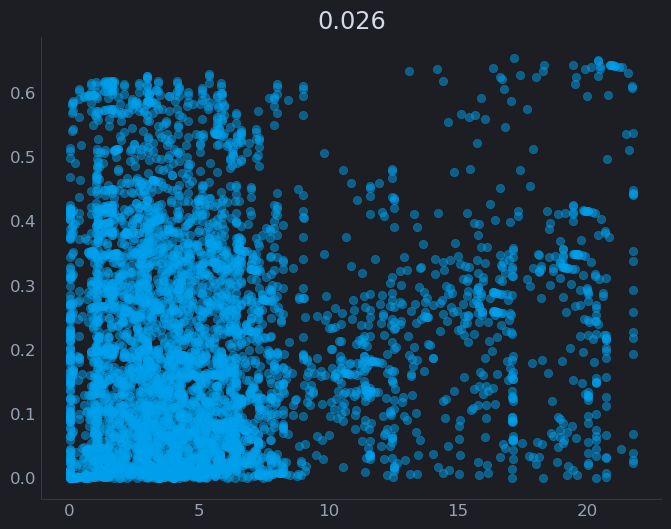

<Axes: title={'center': '0.642'}>

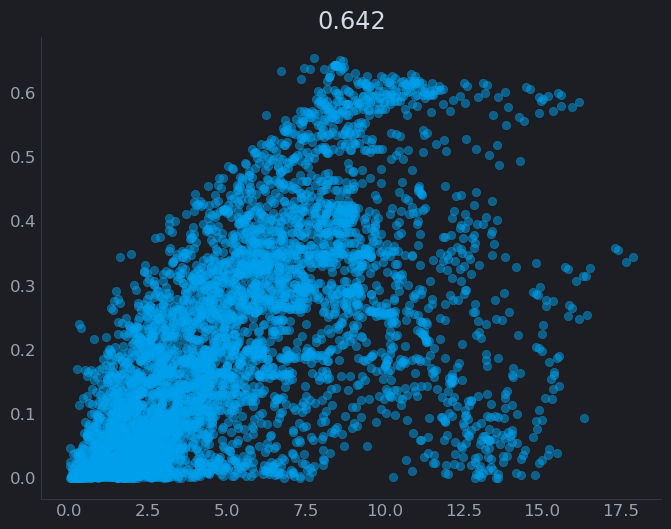

In [97]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
def plot_corr(x, y):
    ax = sns.scatterplot(x=x, y=y, edgecolor=None, alpha=0.5)
    ax.set_title(f'{spearmanr(x, y).statistic:.3f}')
    return ax

plot_corr(pdist(l_eig_vals, 'euclidean'), pdist(e_forms, 'euclidean'))
plt.show()
plot_corr(pdist(eig_vals, 'euclidean'), pdist(e_forms, 'euclidean'))

In [104]:
from pymatgen.symmetry.structure import SymmetrizedStructure
from baysic.feature_space import FeatureSpace
from tqdm import tqdm


all_coords = []
for s in tqdm(combo['symm'].values):
    coords = []
    s: SymmetrizedStructure = s
    fs = FeatureSpace(s.get_space_group_info()[1])
    for iset in s.equivalent_indices:
        for i in iset:
            if fs.asu.is_inside(s.frac_coords[i]):
                coords.append(s.frac_coords[i])
                break
    all_coords.append(np.array(coords))

combo['all_coords'] = all_coords

  0%|          | 0/5025 [00:00<?, ?it/s]

100%|██████████| 5025/5025 [01:01<00:00, 82.09it/s] 


In [118]:
np.linalg.norm(combo['all_coords'].iloc[504] - combo['all_coords'].iloc[503], axis=1).mean()

0.5

In [206]:
import itertools
from baysic.utils import upper_tri
def pairwise_coord_e_form(df: pd.DataFrame):
    coord_dists = []
    e_form_dists = []
    lat_a_dists = []
    for i, j in itertools.combinations(df.index, 2):
        try:
            coord_dists.append(np.linalg.norm(df.loc[i, 'all_coords'] - df.loc[j, 'all_coords'], axis=1).mean())
        except ValueError as e:
            coord_dists.append(np.nan)
        e_form_dists.append(df.loc[i, 'e_form'] - df.loc[j, 'e_form'])
        lat_a_dists.append(df.loc[i, 'lat_a'] - df.loc[j, 'lat_a'])
    return pd.DataFrame({'coord_dist': coord_dists, 'e_form_dist': e_form_dists, 'lat_dist': lat_a_dists, 'dofs': df.iloc[0]['total_dof']})

found_all = combo['wsyms'].str.count('_') + 1 == np.array([ac.shape[0] for ac in combo['all_coords']])
combo['all_wp_diff'] = [len(syms.split('_')) == len(set(syms.split('_'))) for syms in combo['wsyms']]
combo['total_dof'] = [sum([wp.get_dof() for wp in wps]) for wps in combo['wps']]
dist_df = combo[found_all].query('total_dof > 2 and all_wp_diff').groupby(['formula_pretty', 'run_sg', 'wsyms']).apply(pairwise_coord_e_form)
dist_df = dist_df.reset_index().dropna()

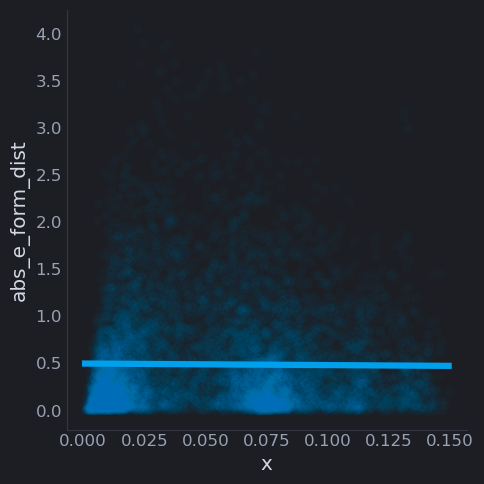

In [213]:
dist_df['abs_e_form_dist'] = abs(dist_df['e_form_dist'])
sns.lmplot(dist_df.eval('x = coord_dist'), x='x', y='abs_e_form_dist', scatter_kws=dict(edgecolor=None, alpha=0.02))

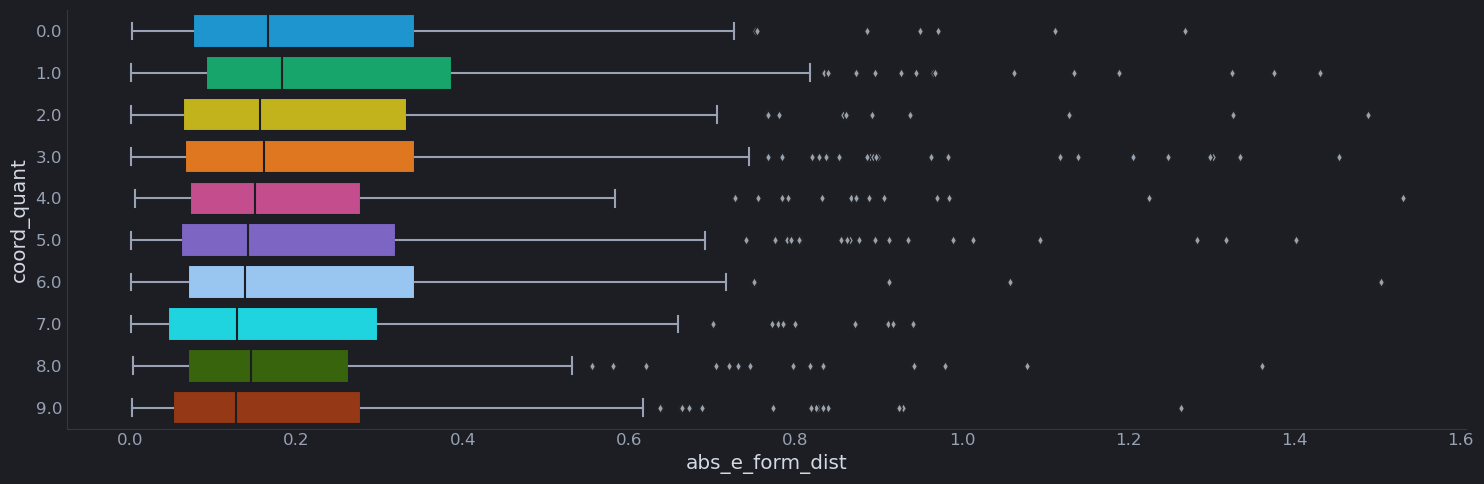

In [237]:
dist_df['coord_quant'] = (np.argsort(dist_df['coord_dist']) // (dist_df.shape[0] / 10)).astype('category')
sns.catplot(dist_df.query('formula_pretty == "Rb3PrCl6"'), y='coord_quant', x='abs_e_form_dist', kind='box', **rp.boxstyle(), aspect=3)

In [234]:
pd.value_counts(dist_df['formula_pretty'])

formula_pretty
Ba2PrSbO6    1960
Rb3PrCl6     1960
Sr2MgIrO6     971
Ba2ErSbO6     971
K2LiInF6      970
Al4Cu2O7      780
Ba2YRuO6      780
NaPb2IO6      606
K2LiCrF6      576
K2NaInF6      408
Ba2YbNbO6     405
KRb2ScF6      380
K2NaAlF6      256
K2NaAlH6      193
Ba2UNiO6      190
Tb4Al         190
Ba2YIrO6       10
Name: count, dtype: int64

In [2]:
import pandas as pd
import seaborn as sns
import rho_plus as rp
from baysic.utils import quick_view, json_to_df
IS_DARK = True
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)
rp.bokeh_setup(IS_DARK)

from copy import deepcopy

import torch
from baysic.pyro_generator import SystemStructureModel
from pymatgen.core import Composition
from baysic.structure_evaluation import point_energy
from baysic.lattice import CubicLattice

No module named 'phonopy'


In [3]:
mod = SystemStructureModel(
    Composition({'Mg': 8, 'Al': 16, 'O': 32}),  # array([  21,  108,  437,  530,  930,  983, 1102, 1424, 1458, 1560, 1760])
    CubicLattice
)

dfs = []

num_cases = 10
seed = 20
while len(dfs) <= num_cases:    
    torch.manual_seed(seed)
    try:
        coords, lat, elems, wsets, sg = mod.forward()    

        new_structs = mod.to_structures()[:50]
        if sum(wset.dof for wset in wsets) == 0 or len(new_structs) <= 10:
            continue
        gen_coords = mod.to_gen_coords().numpy()[:len(new_structs)]
        df = pd.DataFrame({
            'struct': new_structs,
            'coords': list(gen_coords),
            'e_form': [point_energy(deepcopy(struct)) for struct in new_structs],
        })
        df['wps'] = [wsets for _ in range(len(new_structs))]
        df['lat_a'] = [lat[0, 0].item() for _ in range(len(new_structs))]
        dfs.append(df)
        print('.', end='', sep='')
    except ValueError as e:        
        if 'assignment' not in str(e):
            raise e
        print('!', end='', sep='')
    finally:
        seed += 1


df = pd.concat(dfs)
df['sg'] = [wps[0].group.number for wps in df['wps']]
df['wp_letters'] = ['_'.join([wp.wp.letter for wp in wps]) for wps in df['wps']]
from baysic.utils import df_to_json
df_to_json(df.drop(columns=['wps']), 'coords2.json')

!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [8]:

# df = json_to_df('coords.json')

In [ ]:
# df['sg'] = [wps[0].group.number for wps in df['wps']]
# df['wps'] = ['_'.join([wp.wp.letter for wp in wps]) for wps in df['wps']]
# df.head()

In [10]:
df_coords = pd.DataFrame(df['coords'].values.tolist())
cnames = [f'c{i + 1}' for i in df_coords.columns]
df[cnames] = df_coords
df.head()

,struct,coords,e_form,wps,lat_a,sg,wp_letters,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,"[[4.20033783 4.20033783 4.20033783] Al, [5.880...","[0.4447898, 0.3170346, 0.4971278, 0.74719703, ...",0.635993,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.720541,212,b_e_d_c_c,0.444790,0.317035,0.497128,0.747197,0.449385,0.95334,NaN,NaN,NaN,NaN
1,"[[4.20033783 4.20033783 4.20033783] Al, [5.880...","[0.32978445, 0.2668608, 0.33047786, 0.74719703...",0.457893,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.720541,212,b_e_d_c_c,0.329784,0.266861,0.330478,0.747197,0.449385,0.95334,NaN,NaN,NaN,NaN
2,"[[4.20033783 4.20033783 4.20033783] Al, [5.880...","[0.59289515, 0.38573486, 0.3872667, 0.74719703...",0.004725,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.720541,212,b_e_d_c_c,0.592895,0.385735,0.387267,0.747197,0.449385,0.95334,NaN,NaN,NaN,NaN
3,"[[4.20033783 4.20033783 4.20033783] Al, [5.880...","[0.60987765, 0.39402515, 0.43764192, 0.7471970...",-0.110138,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.720541,212,b_e_d_c_c,0.609878,0.394025,0.437642,0.747197,0.449385,0.95334,NaN,NaN,NaN,NaN
4,"[[4.20033783 4.20033783 4.20033783] Al, [5.880...","[0.60162294, 0.39451647, 0.55674714, 0.7471970...",-0.123843,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.720541,212,b_e_d_c_c,0.601623,0.394516,0.556747,0.747197,0.449385,0.95334,NaN,NaN,NaN,NaN


In [23]:
df['sg_letters'] = df['sg'].astype(str) + df['wp_letters']

In [20]:
df.groupby('wp_letters').first()['sg']

wp_letters
a_e_d_c_c                212
b_e_d_c_c                212
c_a_k_k_i_i_h_e          200
d_a_i_g_g_g_f_e_e_e_e    215
d_b_h_j_g_g_f_f          207
d_b_j_h_g_g_f_e          221
d_b_l_i_i_h_e            200
Name: sg, dtype: int64

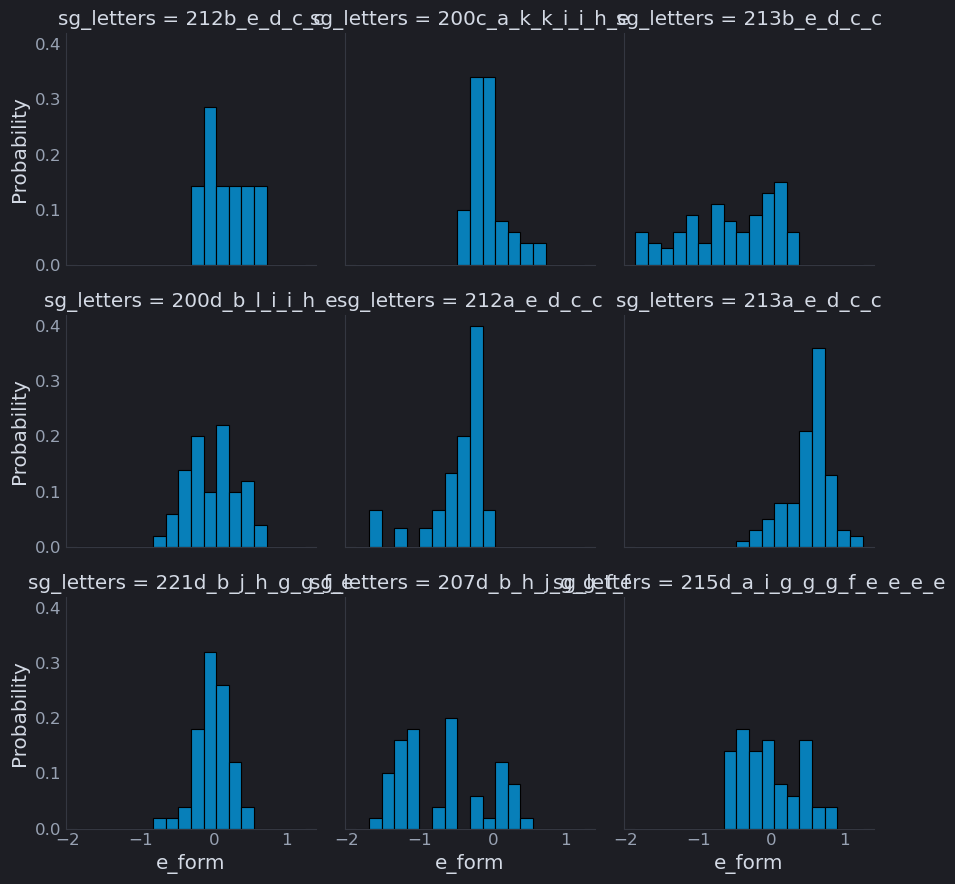

In [24]:
sns.displot(df, col='sg_letters', x='e_form', col_wrap=3, stat='probability', common_bins=True, common_norm=False, height=3)

In [29]:
from baysic.structure_evaluation import relaxed_energy
best = df.sort_values('e_form')
best_relaxed, best_energy = relaxed_energy(deepcopy(best.iloc[0]['struct']), long=True)

In [31]:
quick_view(best_relaxed)

In [63]:
import xarray as xr

coords = {col: ('i', df[col]) for col in cnames + ['sg', 'lat_a']}
coords['i'] = np.arange(df.shape[0])
da = xr.DataArray(df.reset_index()['e_form'], dims={'i': df.shape[0]}, coords=coords)
da

<xarray.DataArray 'e_form' (i: 494)>
array([ 6.35992646e-01,  4.57892537e-01,  4.72545624e-03, -1.10138178e-01,
       -1.23843431e-01,  5.81381917e-01,  2.94738770e-01,  1.39333606e-01,
        7.12647438e-02, -1.70598507e-01,  4.48766351e-01, -2.23048449e-01,
        2.89067149e-01, -5.08974791e-02, -3.51358652e-02,  6.03906989e-01,
       -1.33180141e-01, -1.75316334e-02, -1.63454890e-01,  4.13458943e-01,
        2.03776360e-03, -7.87051916e-02,  1.16548777e-01, -8.70983601e-02,
       -1.42335892e-01, -2.17785239e-01,  7.79153109e-02, -3.34022045e-02,
       -1.05583429e-01, -1.10996485e-01,  2.35961676e-02,  6.30819798e-03,
       -6.99439049e-02, -6.20377064e-02,  2.94841647e-01,  2.36334801e-02,
        4.04404521e-01, -1.46538734e-01,  2.99649835e-01,  6.96156621e-01,
       -2.99335122e-01, -1.82121277e-01,  1.38629556e-01, -4.00522470e-01,
       -4.86160517e-02,  3.40530515e-01,  7.89541006e-02, -2.44641066e-01,
       -6.66313171e-02, -1.65813088e-01, -2.71130562e-01, -4.05104041e-01,
       -1.48662210e-01, -3.03349018e-01, -2.51763463e-01, -2.86374331e-01,
       -1.15122318e-01, -2.68355012e-01, -3.32256913e-01, -2.13734388e-01,
       -3.10956359e-01, -1.87155008e-01, -4.33212638e-01, -2.87507296e-01,
       -3.72837782e-01, -7.45247900e-01, -3.44609499e-01,  1.13762975e-01,
       -8.58040690e-01,  1.26248837e-01, -6.56814337e-01, -5.79752564e-01,
        5.09978533e-02, -5.70513844e-01, -1.21665728e+00, -5.28152108e-01,
       -1.62340641e-01, -5.03443241e-01, -8.15480113e-01, -1.28391230e+00,
...
        6.25819087e-01,  3.01768780e-02,  5.17132401e-01,  3.81748319e-01,
        7.08881974e-01,  7.20085979e-01,  9.79754925e-02, -1.61755681e-01,
        5.71984053e-02, -5.61957359e-02,  5.07813096e-01,  4.84409928e-01,
        5.86752534e-01,  6.81601882e-01,  4.22485948e-01, -2.28824139e-01,
        5.93973756e-01,  6.97550416e-01,  6.69418216e-01,  7.01139331e-01,
        7.48985410e-01,  8.23844552e-01,  2.77879953e-01,  5.76122642e-01,
        7.53545403e-01,  5.62401414e-01,  1.00237715e+00,  5.72368979e-01,
        7.56379008e-01, -4.33840752e-02, -4.57049608e-02, -9.99307632e-03,
       -1.59099102e-01,  6.32451892e-01, -4.62571383e-01,  7.44301677e-01,
       -4.79720831e-01, -3.90726447e-01, -1.08720064e-01, -3.04385066e-01,
       -3.04636121e-01,  7.73153305e-02,  1.96856260e-02,  5.06495357e-01,
        4.43068624e-01, -4.92959499e-01, -3.92009258e-01,  5.27451396e-01,
       -4.85111475e-01,  6.18245721e-01, -5.46366215e-01, -5.70087194e-01,
       -3.85713458e-01,  7.23549128e-02, -3.65478873e-01,  1.35028958e-01,
        4.03304935e-01, -2.74918675e-01,  4.56437230e-01, -1.10633373e-01,
       -1.21141672e-02,  1.71365142e-01, -3.45504284e-01, -2.75322437e-01,
        5.25724292e-01,  2.51365662e-01,  5.28867841e-01, -2.89313078e-01,
        3.28349471e-01,  4.98530269e-01,  3.58956695e-01, -4.43202019e-01,
       -1.50607109e-01, -1.35003805e-01, -4.99978662e-01, -3.38206172e-01,
       -5.32297254e-01, -5.82831740e-01])
Coordinates: (12/13)
    c1       (i) float32 0.4448 0.3298 0.5929 0.6099 ... 0.3793 0.5863 0.5863
    c2       (i) float32 0.317 0.2669 0.3857 0.394 ... 0.7666 0.7666 0.636 0.636
    c3       (i) float32 0.4971 0.3305 0.3873 0.4376 ... 0.7101 0.2049 0.2049
    c4       (i) float32 0.7472 0.7472 0.7472 0.7472 ... 0.9319 0.8563 0.8563
    c5       (i) float32 0.4494 0.4494 0.4494 0.4494 ... 0.6728 0.7637 0.7637
    c6       (i) float32 0.9533 0.9533 0.9533 0.9533 ... 0.3541 0.3541 0.3541
    ...       ...
    c8       (i) float64 nan nan nan nan nan ... 0.7272 0.7272 0.7272 0.7272
    c9       (i) float64 nan nan nan nan nan nan nan ... nan nan nan nan nan nan
    c10      (i) float64 nan nan nan nan nan nan nan ... nan nan nan nan nan nan
    sg       (i) int64 212 212 212 212 212 212 212 ... 215 215 215 215 215 215
    lat_a    (i) float64 6.721 6.721 6.721 6.721 ... 7.672 7.672 7.672 7.672
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 485 486 487 488 489 490 491 492 493

In [64]:
pd.value_counts(df['sg'])

sg
213    200
200    100
207     50
221     50
215     50
212     44
Name: count, dtype: int64

In [65]:
import hvplot.xarray
import warnings
from scipy.special import logit

warnings.filterwarnings('ignore', category=FutureWarning)
da.query(i='sg == 213').hvplot.scatter(x='c1', y='c2', color='e_form', xlim=(0, 1), ylim=(0, 1), aspect=1, alpha=0.2, cmap=rp.SEQUENTIAL_DATA['inferna'][::-1], cnorm='linear',
                                       hover_cols='all')

:Scatter   [c1]   (c2,e_form,i,c3,c4,c5,c6,c7,c8,c9,c10,sg,lat_a)

In [67]:
import itertools
import numpy as np
from scipy.spatial import distance as dist
def pdist_e_form(df: pd.DataFrame):
    coord_dists = []
    e_form_dists = []
    lat_a_dists = []
    for i, j in itertools.combinations(range(df.shape[0]), 2):
        try:
            coord_dists.append(dist.euclidean(*df.iloc[[i, j]]['coords'].values))
        except ValueError as e:
            raise e
            coord_dists.append(np.nan)
        e_form_dists.append(df.iloc[i]['e_form'] - df.iloc[j]['e_form'])
        lat_a_dists.append(df.iloc[i]['lat_a'] - df.iloc[j]['lat_a'])
    return pd.DataFrame({'coord_dist': coord_dists, 'e_form_dist': e_form_dists, 'lat_dist': lat_a_dists, 'dofs': len(df.iloc[0]['coords'])})

dist_df = df.groupby('sg_letters').apply(pdist_e_form)
dist_df.head()

coord_dist  e_form_dist  lat_dist  dofs
sg_letters                                                   
200c_a_k_k_i_i_h_e 0    0.256088    -0.639043       0.0     8
                   1    0.038499     0.098044       0.0     8
                   2    0.066112    -0.017604       0.0     8
                   3    0.091456     0.128319       0.0     8
                   4    0.269190    -0.448595       0.0     8

In [130]:
# dist_df.to_pickle('dists.pkl')
# dist_df = pd.read_pickle('dists.pkl')

In [69]:
import hvplot.pandas
dist_df['abs_dist'] = abs(dist_df['e_form_dist'])
dist_df.hvplot.hexbin(x='coord_dist', y='abs_dist')

:HexTiles   [coord_dist,abs_dist]

In [70]:
dist_df.corr('spearman')

,coord_dist,e_form_dist,lat_dist,dofs,abs_dist
coord_dist,1.000000,0.020994,-0.008392,0.181567,0.177742
e_form_dist,0.020994,1.000000,-0.064945,-0.004892,0.186458
lat_dist,-0.008392,-0.064945,1.000000,0.000000,-0.238225
dofs,0.181567,-0.004892,0.000000,1.000000,-0.080865
abs_dist,0.177742,0.186458,-0.238225,-0.080865,1.000000


In [74]:
df.reset_index().sort_values('e_form')

,index,struct,coords,e_form,wps,lat_a,sg,wp_letters,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,sg_letters
291,47,"[[6.37972003 6.37972003 6.37972003] Al, [4.556...","[0.4197825, 0.6039789, 0.8505713, 0.053821266,...",-1.865864,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,7.291109,213,b_e_d_c_c,0.379331,0.766617,0.710134,0.931889,0.672773,0.354093,0.527276,0.727156,NaN,NaN,213b_e_d_c_c
245,1,"[[6.37972003 6.37972003 6.37972003] Al, [4.556...","[0.375975, 0.6709242, 0.79659945, 0.053821266,...",-1.797759,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,7.291109,213,b_e_d_c_c,0.329784,0.266861,0.330478,0.747197,0.449385,0.953340,NaN,NaN,NaN,NaN,213b_e_d_c_c
247,3,"[[6.37972003 6.37972003 6.37972003] Al, [4.556...","[0.4269489, 0.6308935, 0.7828636, 0.053821266,...",-1.751269,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,7.291109,213,b_e_d_c_c,0.609878,0.394025,0.437642,0.747197,0.449385,0.953340,NaN,NaN,NaN,NaN,213b_e_d_c_c
248,4,"[[6.37972003 6.37972003 6.37972003] Al, [4.556...","[0.472254, 0.9108689, 0.12737119, 0.053821266,...",-1.705908,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,7.291109,213,b_e_d_c_c,0.601623,0.394516,0.556747,0.747197,0.449385,0.953340,NaN,NaN,NaN,NaN,213b_e_d_c_c
262,18,"[[6.37972003 6.37972003 6.37972003] Al, [4.556...","[0.4497103, 0.59613305, 0.928888, 0.053821266,...",-1.697143,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,7.291109,213,b_e_d_c_c,0.373543,0.952203,0.710134,0.931889,0.672773,0.354093,0.488777,0.766432,NaN,NaN,213b_e_d_c_c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,27,"[[2.48392421 2.48392421 2.48392421] Al, [0.827...","[0.37776718, 0.52161896, 0.61147285, 0.2002620...",0.971797,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.623798,213,a_e_d_c_c,0.404650,0.875298,0.742030,0.888630,0.672773,0.354093,0.488777,0.727156,NaN,NaN,213a_e_d_c_c
226,32,"[[2.48392421 2.48392421 2.48392421] Al, [0.827...","[0.3709837, 0.59051895, 0.7541527, 0.20026207,...",0.978729,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.623798,213,a_e_d_c_c,0.404650,0.875298,0.710134,0.931889,0.672773,0.354093,0.527276,0.727156,NaN,NaN,213a_e_d_c_c
442,48,"[[2.46919191 2.46919191 2.46919191] Al, [0.823...","[0.33260128, 0.5835234, 0.4677943, 0.14284775,...",1.002377,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.584512,213,a_e_d_c_c,0.586287,0.635955,0.204895,0.856286,0.763687,0.354093,0.669721,0.727156,NaN,NaN,213a_e_d_c_c
220,26,"[[2.48392421 2.48392421 2.48392421] Al, [0.827...","[0.3926909, 0.474451, 0.7506546, 0.20026207, 0...",1.234884,[WyckoffSet(\n (ymin): LinearSpline()\n (yma...,6.623798,213,a_e_d_c_c,0.373543,0.952203,0.791706,0.633132,0.763687,0.354093,0.783364,0.727156,NaN,NaN,213a_e_d_c_c


In [157]:
from baysic.pyro_wp import WyckoffSet
import plotly.graph_objects as go

wset = WyckoffSet(205, 'd')
x, y, z = np.array(wset.asu.shape_vertices()).astype(float).T

go.Figure(go.Mesh3d(x=x, y=y, z=z, alphahull=0, flatshading=True))

In [158]:
wset.to_asu(torch.tensor(df.sort_values('e_form')[['c1', 'c2', 'c3']].values[:10]))

tensor([[0.0265, 0.2777, 0.0095],
        [0.2629, 0.0215, 0.0032],
        [0.2340, 0.0615, 0.0397],
        [0.2717, 0.0201, 0.0079],
        [0.2670, 0.0229, 0.0064],
        [0.0229, 0.2695, 0.0157],
        [0.0299, 0.1994, 0.0128],
        [0.0229, 0.2695, 0.0157],
        [0.0265, 0.2777, 0.0095],
        [0.2421, 0.0353, 0.0103]])

In [160]:
from baysic.utils import quick_view

quick_view(df.sort_values('e_form')['struct'].iloc[0])

In [162]:
quick_view(df.sort_values('e_form')['struct'].iloc[1])

In [196]:
vals = wset.to_all_positions(torch.tensor([[0.05, 0.25, 0.1], [0.25, 0.05, 0.1]])) % 1
inds = torch.argsort(vals @ torch.tensor([[100.0, 10.0, 1.0]]).T, dim=1).squeeze()
print(vals[0, inds[0]].numpy().round(2))
print(vals[1, inds[1]].numpy().round(2))

[[0.05 0.25 0.1 ]
 [0.05 0.25 0.6 ]
 [0.1  0.05 0.25]
 [0.1  0.45 0.75]
 [0.25 0.1  0.05]
 [0.25 0.4  0.55]
 [0.25 0.6  0.05]
 [0.25 0.9  0.55]
 [0.4  0.55 0.25]
 [0.4  0.95 0.75]
 [0.45 0.75 0.1 ]
 [0.45 0.75 0.6 ]
 [0.55 0.25 0.4 ]
 [0.55 0.25 0.9 ]
 [0.6  0.05 0.25]
 [0.6  0.45 0.75]
 [0.75 0.1  0.45]
 [0.75 0.4  0.95]
 [0.75 0.6  0.45]
 [0.75 0.9  0.95]
 [0.9  0.55 0.25]
 [0.9  0.95 0.75]
 [0.95 0.75 0.4 ]
 [0.95 0.75 0.9 ]]
[[0.05 0.1  0.25]
 [0.05 0.4  0.75]
 [0.1  0.25 0.05]
 [0.1  0.25 0.55]
 [0.25 0.05 0.1 ]
 [0.25 0.45 0.6 ]
 [0.25 0.55 0.1 ]
 [0.25 0.95 0.6 ]
 [0.4  0.75 0.05]
 [0.4  0.75 0.55]
 [0.45 0.6  0.25]
 [0.45 0.9  0.75]
 [0.55 0.1  0.25]
 [0.55 0.4  0.75]
 [0.6  0.25 0.45]
 [0.6  0.25 0.95]
 [0.75 0.05 0.4 ]
 [0.75 0.45 0.9 ]
 [0.75 0.55 0.4 ]
 [0.75 0.95 0.9 ]
 [0.9  0.75 0.45]
 [0.9  0.75 0.95]
 [0.95 0.6  0.25]
 [0.95 0.9  0.75]]
